## Issue: hand detected as human
客户要求，人体面积50%以内不纳入person类检出（实测场景下多为挥手）
试图最低限度修改模型，取消小面积肢体的检出

### try1
冻结所有网络前置层，在每组anchor输出向量中添加一维手部检测，在[HGP](https://paperswithcode.com/dataset/hgp) / [EgoHands](https://public.roboflow.com/object-detection/hands) 数据集上fine-tune

In [15]:
import sys
import torch
import torch.nn as nn
# import matplotlib
# matplotlib.use('TkAgg')
sys.path.append('..')

import object_detection.yolov5_ultralytics.model as yolo_u

yolo_u.ACTIVATION = nn.SiLU
model = yolo_u.yolov5n(80, weights="../.yolov5_checkpoints/yolov5n_sd.pt").eval()

transferred 349/349 items from ../.yolov5_checkpoints/yolov5n_sd.pt


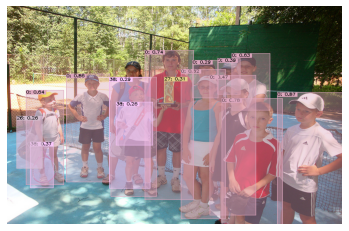

In [16]:
# Test raw model
import cv2
from test_utils.detection_test import detect, uniform_scale
from test_utils.detection_visualize import Canvas
image = cv2.imread('/Volumes/ASM236X/coco/images/val2017/000000001000.jpg')
image = uniform_scale(image, 640)
canvas = Canvas(backend='plt')
detect(model, image, canvas)
del canvas

In [17]:
# Transfer box/obj weight data
print(model.detect.m)
for layer in model.detect.m:
    print(layer.weight.shape, layer.bias.shape)
# 255 = 3x(4+1+80)  bs, self.na, self.no, ny, nx
raw_m = model.detect.m
hand_m = nn.ModuleList(nn.Conv2d(x, 6 * 3, 1) for x in (64, 128, 256))  # output conv
for i in range(3):
    for j in range(3):
        hand_m[i].weight.data[6*j:6*j+5] = raw_m[i].weight.data[85*j:85*j+5].clone()  # 0-5 85-90 170-175
        hand_m[i].bias.data[6*j:6*j+5]  = raw_m[i].bias.data[85*j:85*j+5].clone()
        hand_m[i].weight.data[6*j+5] = 0
        hand_m[i].bias.data[6*j+5] = 1
model.detect.nc = 1
model.detect.no = 5+1
setattr(model.detect, 'm', hand_m)

ModuleList(
  (0): Conv2d(64, 255, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(128, 255, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(256, 255, kernel_size=(1, 1), stride=(1, 1))
)
torch.Size([255, 64, 1, 1]) torch.Size([255])
torch.Size([255, 128, 1, 1]) torch.Size([255])
torch.Size([255, 256, 1, 1]) torch.Size([255])


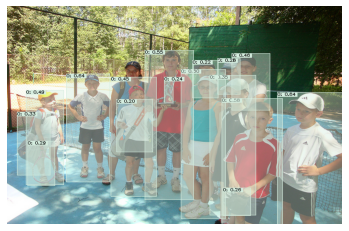

In [18]:
# Test if new model works properly
import cv2
from test_utils.detection_test import detect, uniform_scale
from test_utils.detection_visualize import Canvas
image = cv2.imread('/Volumes/ASM236X/coco/images/val2017/000000001000.jpg')
image = uniform_scale(image, 640)
canvas = Canvas(backend='plt')
detect(model, image, canvas)


In [19]:
# Freeze model for fine-tuning (train obj loss only)
frozen_params = [k for k, _ in model.named_parameters()]
frozen_params = [x for x in frozen_params if 'detect.m' not in x]

for k, v in model.named_parameters():
        v.requires_grad = True
        if frozen_params is not None and any(x == k for x in frozen_params):
            v.requires_grad = False

print('trainable parameters:')
for name, x in model.named_parameters():
    if x.requires_grad:
        print(name, x.shape)


trainable parameters:
detect.m.0.weight torch.Size([18, 64, 1, 1])
detect.m.0.bias torch.Size([18])
detect.m.1.weight torch.Size([18, 128, 1, 1])
detect.m.1.bias torch.Size([18])
detect.m.2.weight torch.Size([18, 256, 1, 1])
detect.m.2.bias torch.Size([18])


In [20]:
# Process data
# 只需要手部标注 (cid=2)
if False:  # already processed
    import os
    label_mapper = {
        0: DefaultSettings.names.index("cell phone"),  # phone
        1: 80,  # gun
        2: 81,  # hand
    }
    output_root = "/Volumes/ASM236X/datasets/HGP/labels"
    labels_root = "/Volumes/ASM236X/datasets/HGP/labels_raw"
    if not os.path.exists(labels_root):
        os.system(f"mv {output_root} {labels_root}")
    else:
        os.system(f"rm -r {output_root}")
    for dataset in ("train2017", "val2017"):
        image_dir = f"{labels_root}/{dataset}"
        output_dir = f"{output_root}/{dataset}"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # traverse through images
        print(image_dir)
        assert os.path.exists(image_dir)
        for file_name in os.listdir(image_dir):
            if not file_name.startswith("._") and file_name.endswith(".txt"):
                labels = []
                with open(f"{image_dir}/{file_name}", "r") as f:
                    for line in f.readlines():
                        c, x, y, w, h = [float(m) for m in line.split(" ")]
                        c = label_mapper[int(c)]
                        line = f"{c} {x} {y} {w} {h}"
                        labels.append(line)

                with open(f"{output_dir}/{file_name}", "w") as f:
                    for line in labels:
                        f.write(f"{line}\n")



/Volumes/ASM236X/HGP/labels/train2017
/Volumes/ASM236X/HGP/labels/val2017


In [21]:
# Fine-tune on HGP dataset
if False:
    from object_detection.training_utils.default_settings import DefaultSettings
    from object_detection.training_utils.trainer import train

    settings = DefaultSettings()
    settings.trainset_path = "/Volumes/ASM236X/HGP/images/train2017"
    settings.valset_path = "/Volumes/ASM236X/HGP/images/val2017"
    settings.lr0 = 0.005
    settings.nc = 1
    settings.names = ['hand']
    settings.auto_anchor = False
    settings.batch_size = 8
    settings.frozen_params = frozen_params
    settings.save_dir = "runs/yolov5n_hand_only"
    train(model, settings, device='cpu')


2022-06-16 10:16:24.004 | SUCCESS  | object_detection.training_utils.general:check_before_training:128 - model check passed


albumentations: Blur(always_apply=False, p=0.01, blur_limit=(3, 7)), MedianBlur(always_apply=False, p=0.01, blur_limit=(3, 7)), ToGray(always_apply=False, p=0.01), CLAHE(always_apply=False, p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


Scanning '/Volumes/ASM236X/HGP/labels/train2017' images and labels...1989 found, 0 missing, 147 empty, 0 corrupt: 100%|██████████| 1989/1989 [00:04<00:00, 458.35it/s] 
2022-06-16 10:16:28.540 | INFO     | object_detection.training_utils.yolov5_dataset_loader_pack.datasets:cache_labels:593 - New cache created: /Volumes/ASM236X/HGP/labels/train2017.cache
Scanning '/Volumes/ASM236X/HGP/labels/val2017' images and labels...210 found, 0 missing, 18 empty, 0 corrupt: 100%|██████████| 210/210 [00:05<00:00, 41.95it/s]
2022-06-16 10:16:50.847 | INFO     | object_detection.training_utils.yolov5_dataset_loader_pack.datasets:cache_labels:593 - New cache created: /Volumes/ASM236X/HGP/labels/val2017.cache



     epoch   gpu_mem       box       obj       cls


     0/299        0G   0.05785   0.03571         0: 100%|██████████| 249/249 [04:58<00:00,  1.20s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:25<00:00,  1.81s/it]
2022-06-16 10:22:14.622 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.028435745653707246, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.132       0.25     0.0806     0.0226      0.173

     epoch   gpu_mem       box       obj       cls


     1/299        0G   0.05636   0.02923         0: 100%|██████████| 249/249 [06:08<00:00,  1.48s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.79s/it]
2022-06-16 10:29:01.839 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.05866221571817454, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.215      0.279      0.157     0.0477      0.243

     epoch   gpu_mem       box       obj       cls


     2/299        0G   0.05815   0.02579         0: 100%|██████████| 249/249 [07:32<00:00,  1.82s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.78s/it]
2022-06-16 10:37:13.423 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.06108921287746958, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.244      0.307      0.177     0.0482      0.272

     epoch   gpu_mem       box       obj       cls


     3/299        0G   0.06018   0.02467         0: 100%|██████████| 249/249 [08:07<00:00,  1.96s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.78s/it]
2022-06-16 10:45:59.740 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.06529453248386934, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.292        0.3      0.194      0.051      0.296

     epoch   gpu_mem       box       obj       cls


     4/299        0G   0.05967   0.02405         0: 100%|██████████| 249/249 [07:33<00:00,  1.82s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.81s/it]


                 all        210        280      0.259      0.304        0.2     0.0488       0.28

     epoch   gpu_mem       box       obj       cls


     5/299        0G   0.06115   0.02394         0: 100%|██████████| 249/249 [07:26<00:00,  1.79s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.77s/it]


                 all        210        280      0.246        0.3      0.184      0.049      0.271

     epoch   gpu_mem       box       obj       cls


     6/299        0G   0.06042   0.02477         0: 100%|██████████| 249/249 [07:40<00:00,  1.85s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it]
2022-06-16 11:10:38.662 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.06781763964328984, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.235      0.379      0.207     0.0524       0.29

     epoch   gpu_mem       box       obj       cls


     7/299        0G   0.05901   0.02368         0: 100%|██████████| 249/249 [07:59<00:00,  1.93s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:40<00:00,  2.92s/it]
2022-06-16 11:19:19.031 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.06937609782643796, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.232      0.359      0.203     0.0546      0.282

     epoch   gpu_mem       box       obj       cls


     8/299        0G   0.05911   0.02416         0: 100%|██████████| 249/249 [08:10<00:00,  1.97s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it]
2022-06-16 11:28:09.229 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.06996109614225977, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.248      0.363      0.213     0.0541      0.295

     epoch   gpu_mem       box       obj       cls


     9/299        0G   0.06031   0.02405         0: 100%|██████████| 249/249 [07:44<00:00,  1.87s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.80s/it]


                 all        210        280      0.291      0.296      0.203     0.0528      0.294

     epoch   gpu_mem       box       obj       cls


    10/299        0G   0.06044   0.02398         0: 100%|██████████| 249/249 [07:42<00:00,  1.86s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.81s/it]
2022-06-16 11:44:55.328 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.0797405431718197, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.261      0.368      0.221      0.064      0.305

     epoch   gpu_mem       box       obj       cls


    11/299        0G   0.05943   0.02411         0: 100%|██████████| 249/249 [07:43<00:00,  1.86s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.83s/it]


                 all        210        280      0.282      0.339      0.226      0.061      0.308

     epoch   gpu_mem       box       obj       cls


    12/299        0G   0.05945   0.02354         0: 100%|██████████| 249/249 [07:50<00:00,  1.89s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:40<00:00,  2.86s/it]


                 all        210        280      0.298        0.3       0.23     0.0595      0.299

     epoch   gpu_mem       box       obj       cls


    13/299        0G   0.05906   0.02448         0: 100%|██████████| 249/249 [07:53<00:00,  1.90s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.79s/it]


                 all        210        280      0.312      0.321      0.238     0.0621      0.317

     epoch   gpu_mem       box       obj       cls


    14/299        0G   0.05908    0.0238         0: 100%|██████████| 249/249 [08:09<00:00,  1.97s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:41<00:00,  2.96s/it]


                 all        210        280      0.291      0.332      0.237      0.062       0.31

     epoch   gpu_mem       box       obj       cls


    15/299        0G   0.05972   0.02405         0: 100%|██████████| 249/249 [08:09<00:00,  1.97s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:40<00:00,  2.91s/it]
2022-06-16 12:28:03.956 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.09169194528431923, save model as runs/yolov5n_hand_only.0/best.pt


                 all        210        280      0.293      0.371      0.258     0.0732      0.327

     epoch   gpu_mem       box       obj       cls


    16/299        0G   0.05958   0.02426         0: 100%|██████████| 249/249 [07:30<00:00,  1.81s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.77s/it]


                 all        210        280      0.314      0.328      0.242     0.0649      0.321

     epoch   gpu_mem       box       obj       cls


    17/299        0G   0.05896   0.02383         0: 100%|██████████| 249/249 [07:29<00:00,  1.80s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.81s/it]


                 all        210        280      0.279      0.368      0.246     0.0664      0.317

     epoch   gpu_mem       box       obj       cls


    18/299        0G   0.06027   0.02381         0: 100%|██████████| 249/249 [07:27<00:00,  1.80s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.77s/it]


                 all        210        280      0.296      0.341      0.239      0.066      0.317

     epoch   gpu_mem       box       obj       cls


    19/299        0G   0.05869   0.02357         0: 100%|██████████| 249/249 [07:28<00:00,  1.80s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.76s/it]


                 all        210        280      0.317      0.304      0.231     0.0611       0.31

     epoch   gpu_mem       box       obj       cls


    20/299        0G   0.05935   0.02391         0: 100%|██████████| 249/249 [07:23<00:00,  1.78s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.74s/it]


                 all        210        280      0.345      0.327       0.25     0.0642      0.336

     epoch   gpu_mem       box       obj       cls


    21/299        0G     0.059   0.02392         0: 100%|██████████| 249/249 [07:24<00:00,  1.78s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.75s/it]


                 all        210        280      0.313      0.342      0.249     0.0664      0.327

     epoch   gpu_mem       box       obj       cls


    22/299        0G   0.05951   0.02407         0: 100%|██████████| 249/249 [07:24<00:00,  1.78s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.76s/it]


                 all        210        280      0.291      0.382      0.246     0.0708       0.33

     epoch   gpu_mem       box       obj       cls


    23/299        0G    0.0592    0.0236         0: 100%|██████████| 249/249 [07:27<00:00,  1.80s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:38<00:00,  2.76s/it]


                 all        210        280      0.277      0.375      0.247     0.0672      0.318

     epoch   gpu_mem       box       obj       cls


    24/299        0G   0.05552   0.02304         0:   7%|▋         | 17/249 [00:33<07:37,  1.97s/it]


KeyboardInterrupt: 

transferred 349/349 items from runs/yolov5n_hand_only.0/best.pt


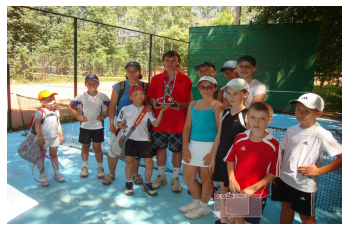

In [25]:
# Try model
model = yolo_u.yolov5n(1, weights="../runs/yolov5n_hand_only.0/best.pt").eval()
image = cv2.imread('/Volumes/ASM236X/coco/images/val2017/000000001000.jpg')
image = uniform_scale(image, 640)
canvas = Canvas(backend='plt')
detect(model, image, canvas)
del canvas

# (Test on HGP)
# from test_utils.detection_test import full_dataset_test
# full_dataset_test(model, '/Volumes/ASM236X/HGP/images/val2017', ['hand'])

In [72]:
# Fuse
import sys
import torch
import torch.nn as nn
# import matplotlib
# matplotlib.use('TkAgg')
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import object_detection.yolov5_ultralytics.model as yolo_u

yolo_u.ACTIVATION = nn.SiLU

hand_model = yolo_u.yolov5n(1, weights="../runs/yolov5n_hand_only.0/best.pt").eval()
raw_model = yolo_u.yolov5n(80, weights="../.yolov5_checkpoints/yolov5n_sd.pt").eval()

hm = hand_model.detect.m
rm = raw_model.detect.m
plot = False

for i in range(3):
    # 85x3 channels each scale
    for j in range(3):
        hf = hm[i].weight.data[6*j+4].clone()
        hf_bias = hm[i].bias.data[6*j+4].clone()
        pf = rm[i].weight.data[85*j+5].clone()
        pf_bias = rm[i].bias.data[85*j+5].clone()

        # plot1
        if plot:
            d1 = pd.DataFrame(enumerate(hf.flatten().tolist()), columns=pd.Index(['channel', 'weight']))
            d2 = pd.DataFrame(enumerate(pf.flatten().tolist()), columns=pd.Index(['channel', 'weight']))
            plt.figure(figsize=(8, 8))
            sns.barplot(data=d1, x='channel', y='weight', color='teal', alpha=0.5, label='hand')
            sns.barplot(data=d2, x='channel', y='weight', color='orange', alpha=0.5, label='human')
            plt.title(f'anchor {i}-{j}')
            plt.legend()
            plt.show()

        # normalize & intersection
        hf = hf / hf.mean() * pf.mean()
        negative = torch.logical_and((hf >0), (pf<0))
        pf -= torch.relu(negative.float()) * hf * 64

        # plot2
        if plot:
            d3 = pd.DataFrame(enumerate(pf.flatten().tolist()), columns=pd.Index(['channel', 'weight']))
            plt.figure(figsize=(8, 8))
            sns.barplot(data=d2, x='channel', y='weight', color='teal', alpha=0.5, label='human')
            sns.barplot(data=d3, x='channel', y='weight', color='deeppink', alpha=0.5, label='human-processed')
            plt.title(f'anchor {i}-{j}')
            plt.legend()
            plt.show()

        # fuse
        rm[i].weight.data[85*j+5] = pf  # 0-5 85-90 170-175

torch.save(raw_model.state_dict(), '../runs/yolov5n_hand_only.0/fuse.pt')

transferred 349/349 items from ../runs/yolov5n_hand_only.0/best.pt
transferred 349/349 items from ../.yolov5_checkpoints/yolov5n_sd.pt


#### Results
| ![](docs/%E6%88%AA%E5%B1%8F2022-06-16%20%E4%B8%8B%E5%8D%887.09.59.png) | ![](docs/%E6%88%AA%E5%B1%8F2022-06-16%20%E4%B8%8B%E5%8D%887.09.10.png) | ![](docs/%E6%88%AA%E5%B1%8F2022-06-16%20%E4%B8%8B%E5%8D%887.06.03.png) |
| -- | -- | -- |
| hf=0 | hf=16 | hf=128 |

结果看，大部分feature在-1层耦合较密，通过抑制权重减少手的预测效果有限，且会导致人形损失(置信度下降)

直接fine-tune能看到部分效果，测试结果达不到要求，考虑加数据进行常规训练

### try2
加数据常规训练，添加HGP数据集训练，看情况清洗数据集